In [21]:
#Initialize the network and parameters
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
candidatos = [[1,2,8],[0,2,3],[8,0,1,3,4],[1,2,4,5,7],[2,3,5,6],[3,4,6,7],[4,5],[3,5],[0,2]] #candidates to build an arc

coste_actual = np.array([[0,1.6,0.8,2,1.6,2.5,3,2.5,0.8],[2,0,0.9,1.2,1.5,2.5,2.7,2.4,1.8], #cost by the current network
                [1.5,1.4,0,1.3,0.9,2,1.6,2.3,0.9],[1.9,2,1.9,0,1.8,2,1.9,1.2,2],
                [3,1.5,2,2,0,1.5,1.1,1.8,1.7],[2.1,2.7,2.2,1,1.5,0,0.9,0.9,2.9],
                [2.8,2.3,1.5,1.8,0.9,0.8,0,1.3,2.1],[2.8,2.2,2,1.1,1.5,0.8,1.9,0,0.3],
                [1,1.5,1.1,2.7,1.9,1.8,2.4,3,0]])


c_arcos = np.array([[-1,1.7,2.7,-1,-1,-1,-1,-1,2.9],[1.7,-1,2.1,3,-1,-1,-1,-1,-1], #cost of the arcs
                    [2.7,2.1,-1,2.6,1.7,-1,-1,-1,2.5],[-1,3,2.6,-1,2.8,2.4,-1,3.2,-1],
                    [-1,-1,1.7,2.8,-1,1.9,3,-1,-1],[-1,-1,-1,2.4,1.9,-1,2.7,2.8,-1],
                    [-1,-1,-1,-1,3,2.7,-1,-1,-1],[-1,-1,-1,3.2,-1,2.8,-1,-1,-1],
                    [2.9,-1,2.5,-1,-1,-1,-1,-1,-1]])

c_estaciones = np.array([2,3,2.2,3,2.5,1.3,2.8,2.2,3.1]) #cost of the stations

demanda = np.array([[0,9,26,19,13,12,13,8,11] #demand between o-d pairs
                   ,[11,0,14,26,7,18,3,6,12]
                   ,[30,19,0,30,24,8,15,12,5],[21,9,11,0,22,16,25,21,23]
                   ,[14,14,8,9,0,20,16,22,21],[26,1,22,24,13,0,16,14,12]
                   ,[8,6,9,23,6,13,0,11,11],[9,2,14,20,18,16,11,0,4]
                   ,[8,7,11,22,27,17,8,12,0]])

n = 9
presupuestos = [5000] #budget limit
eps = 1e-1
itermax = 8
phis = [5] #sparsity penalty coefficient (phi / var(k-1))* var
phis_s_coef = [1] #sparsity penalty for stations = phi_s_coef * phi

distancias = 10000*np.ones((n,n)) #distances between arcs
for i in range(0,9):
    distancias[i,i] = 0
distancias[0,1] = 0.75
distancias[0,2] = 0.7
distancias[0,8] = 0.9

distancias[1,2] = 0.6
distancias[1,3] = 1.1

distancias[2,3] = 1.1
distancias[2,4] = 0.5
distancias[2,8] = 0.7

distancias[3,4] = 0.8
distancias[3,5] = 0.7
distancias[3,7] = 0.8

distancias[4,5] = 0.5
distancias[4,6] = 0.7

distancias[5,6] = 0.5
distancias[5,7] = 0.4
for i in range(0,n):
    for j in range(i+1,n):
        distancias[j,i] = distancias[i,j] #la distancia entre nodos es simetrica
arcos_coefs = np.zeros((n,n))
estaciones_coefs = np.zeros(n)

In [22]:
#constraints for the model

def make_constraints(estaciones,arcos,arcos_prim,f_cur,f_new,f_ij,h,presupuesto):
    constraints = []
    for i,j in product(range(n),repeat = 2): 
        if j in candidatos[i]:
            c = 0
            for o,d in product(range(n),repeat = 2): 
                c += demanda[o,d]*f_ij[n*o+i,n*d+j]
            constraints.append(c <= arcos[i,j]) #sum_{ij}(f_{ij}^{od}) <= a_{ij} \forall i,j
            constraints.append(c + h[i,j] == arcos_prim[i,j]) #sum_{ij}(f_{ij}^{od}) + h_{ij} == a_prim{ij} \forall i,j
    for i,j in product(range(n),repeat = 2): #arcos[i,j] = arcos[j,i]
        constraints.append(arcos[i,j] == arcos[j,i])

    for i,j in product(range(n),repeat =2):
        constraints.append(arcos[i,j] >= 0) #a_{ij} >= 0
        constraints.append(arcos_prim[i,j] >= 0) #a_prim{ij} >= 0
        constraints.append(h[i,j] >= 0) #h_{ij} >= 0

    for i in range(n):
        constraints.append(arcos[i,i] == 0) #a_{ii} = 0
        constraints.append(arcos_prim[i,i] == 0) #a_{ii} = 0
        constraints.append(h[i,i] == 0) #TODO: estos los puedo aprovechar para poner congestión en las estaciones

    for i,j in product(range(n),repeat = 2):
        if j not in candidatos[i]:
            constraints.append(arcos[i,j] == 0) #a_{ij} = 0 \forall j not in candidatos[i]
            constraints.append(arcos_prim[i,j] == 0)
            constraints.append(h[i,j] == 0)
    c = 0
    for i,j in product(range(n),repeat = 2): #sum_{ij}a_{ij}ca_{ij} + sum_{i}s_{i}cs_{i} <= budget_lim
        if j in candidatos[i]:
            c += arcos_prim[i,j]*c_arcos[i,j]/2
    for i in range(n):
        c+= estaciones[i]*c_estaciones[i]
    constraints.append(c <= presupuesto)

    for i,j in product(range(n),repeat = 2): #sum(arcs) <= stations
        if (j in candidatos[i]) and (i<j):
            constraints.append(arcos[i,j] <= estaciones[i]) 
            constraints.append(arcos[i,j] <= estaciones[j])


    for o,d in product(range(n),repeat = 2):           
        if o != d:
            constraints.append(f_cur[o,d] + f_new[o,d] == 1)
        constraints.append(f_cur[o,d] <= 1)
        constraints.append(f_new[o,d] <= 1)
        constraints.append(f_cur[o,d] >= 0)
        constraints.append(f_new[o,d] >= 0)

    for o,d,i,j in product(range(n),repeat = 4):
        constraints.append(f_ij[n*o+i,n*d+j] <= 1)
        constraints.append(f_ij[n*o+i,n*d+j] >= 0)


    for i in range(n):
        constraints.append(estaciones[i] >= 0)

    for o,d in product(range(n),repeat = 2):
        if o == d:
            constraints.append(f_cur[o,d] == 0)
            constraints.append(f_new[o,d] == 0)
        if o != d:
            for i in range(n):
                constraints.append(f_ij[n*o+i,n*d+i] == 0) #no flow between same nodes
                for j in range(n):
                    if j not in candidatos[i]:
                            constraints.append(f_ij[n*o+i,n*d+j] == 0) #no flow through imposible arcs
                if o == i:
                    c = 0
                    for j in range(n):
                        if j in candidatos[i]:
                            c += f_ij[n*o+i,n*d+j]
                            c = c - f_ij[n*o+j,n*d+i]
                    constraints.append(c == 1 - f_cur[o,d]) #origin flow conservation
                if d == i:
                    c = 0
                    for j in range(n):
                        if j in candidatos[i]:
                            c += f_ij[n*o+i,n*d+j]
                            c = c - f_ij[n*o+j,n*d+i]
                    constraints.append(c == -1 + f_cur[o,d]) #destination flow conservation
                if (d!=i) and (o!=i):
                    c = 0
                    for j in range(n):
                        if j in candidatos[i]:
                            c += f_ij[n*o+i,n*d+j]
                            c = c - f_ij[n*o+j,n*d+i]
                    constraints.append(c == 0)  #intermediate arc flow conservation
    return constraints

In [26]:
nsim = 1

for presupuesto in presupuestos:
    for phi in phis:
        for phi_s_coef in phis_s_coef:
            arcos_sol = np.zeros((n,n))
            estaciones_sol = np.zeros(n)
            fij_sol = np.zeros((n**2,n**2))
            fnew_sol = np.zeros((n,n))
            fcur_sol = np.zeros((n,n))
            for iter in range(itermax):
                estaciones = cvx.Variable(n)
                arcos = cvx.Variable((n,n))
                arcos_prim = cvx.Variable((n,n))
                h = cvx.Variable((n,n))
                f_cur = cvx.Variable((n,n))
                f_new = cvx.Variable((n,n))
                f_ij = cvx.Variable((n**2,n**2))

                cost = 0
                for i in range(n):
                    if iter < (itermax -1):
                        cost += (phi)*estaciones[i]*estaciones_coefs[i]*c_estaciones[i]
                    cost += c_estaciones[i]*estaciones[i]/100

                for i,j in product(range(n),repeat = 2):
                    if j in candidatos[i]:
                        if iter < (itermax -1):
                            cost += phi*arcos[i,j]*arcos_coefs[i,j]*c_arcos[i,j]/2
                            cost += cvx.inv_pos(h[i,j]+eps) 
                            #cost += -cvx.log(h[i,j]+eps)/10
                        cost += (c_arcos[i,j]/2)*arcos_prim[i,j]/100
                        


                for o,d,i,j in product(range(n),repeat = 4):
                    if (j in candidatos[i]) and (o != d):
                        cost += f_ij[n*o+i,n*d+j]*distancias[i,j]*demanda[o,d]
                for o,d in product(range(n),repeat = 2):
                    if o != d:
                        cost += f_cur[o,d]*coste_actual[o,d]*demanda[o,d] - cvx.entr(f_cur[o,d]*demanda[o,d]) - f_cur[o,d]*demanda[o,d] - cvx.entr(f_new[o,d]*demanda[o,d]) - f_new[o,d]*demanda[o,d]

                constraints = make_constraints(estaciones,arcos,arcos_prim,f_cur,f_new,f_ij,h,presupuesto)

                if iter == (itermax -1):
                    for i in range(n):
                        if estaciones_sol[i] < 1:
                            constraints.append(estaciones[i] == 0)
                    for i,j in product(range(n),repeat = 2):
                        if (j in candidatos[i]):
                            if (arcos_sol[i,j] < 1):
                                constraints.append(arcos[i,j] == 0)
                                constraints.append(arcos_prim[i,j] == 0)
                                constraints.append(h[i,j] == 0)
                            else:
                                cost += cvx.inv_pos(h[i,j]+eps)
                                #cost += -cvx.log(h[i,j]+eps)/10

                prob = cvx.Problem(cvx.Minimize(cost),constraints)
                print(f"running iteration {iter+1}/{itermax} of simulation {nsim}/{len(presupuestos)*len(phis)*len(phis_s_coef)}")
                assert prob.is_dcp
                prob.solve(solver='MOSEK',verbose=False)

                if iter < (itermax - 1):
                    for i in range(n):
                        estaciones_coefs[i] = 1/(estaciones[i].value + eps)
                        estaciones_sol[i] = estaciones[i].value
                    for i,j in product(range(n),repeat = 2):
                        if j in candidatos[i]:
                            arcos_coefs[i,j] = 500/(500*arcos[i,j].value+eps)
                            arcos_sol[i,j] = arcos[i,j].value
                            print(f"arco {i}-{j}, capacity = {arcos_prim[i,j].value}, slackness = {h[i,j].value}")

            for i in range(n):
                estaciones_sol[i] = estaciones[i].value     
            for i,j in product(range(n),repeat = 2):
                if j in candidatos[i]:
                    arcos_sol[i,j] = arcos[i,j].value
            for o,d,i,j in product(range(n),repeat = 4):
                if (o!=d) and (j in candidatos[i]):
                    fij_sol[n*o+i,n*d+j] = f_ij[n*o+i,n*d+j].value
            for o,d in product(range(n),repeat = 2):
                if (o!=d):
                    fnew_sol[o,d] = f_new[o,d].value
                    fcur_sol[o,d] = f_cur[o,d].value
            nsim += 1


running iteration 1/8 of simulation 1/1
arco 0-1, capacity = 16.3010903043037, slackness = 10.637572577069255
arco 0-2, capacity = 57.281003286525255, slackness = 8.456464152351833
arco 0-8, capacity = 8.160024000934087, slackness = 8.160023741351777
arco 1-0, capacity = 16.301434224145595, slackness = 10.637572577069255
arco 1-2, capacity = 38.71800352926697, slackness = 9.582480847625996
arco 1-3, capacity = 8.022894293995757, slackness = 8.022894042654444
arco 2-0, capacity = 65.25961950164795, slackness = 8.4564641523514
arco 2-1, capacity = 38.71779983087476, slackness = 9.582480847625655
arco 2-3, capacity = 40.29597869504195, slackness = 8.617149316874256
arco 2-4, capacity = 107.49854619920659, slackness = 10.637572577069198
arco 2-8, capacity = 54.72023826488929, slackness = 8.787215695803718
arco 3-1, capacity = 8.022894294133575, slackness = 8.022894042654608
arco 3-2, capacity = 40.28781190836693, slackness = 8.617149316874256
arco 3-4, capacity = 14.249079964409265, slackn

In [27]:
for i,j in product(range(n),repeat = 2):
    if j in candidatos[i] and i<j:
        print(f"arco {i}-{j}, capacity = {arcos_prim[i,j].value}")
        print(f"slackness = {h[i,j].value}")


arco 0-1, capacity = 17.035399185256797
slackness = 10.74638045699778
arco 0-2, capacity = 65.84464081012625
slackness = 8.50651583591172
arco 0-8, capacity = -0.0
slackness = -0.0
arco 1-2, capacity = 56.15966169253372
slackness = 9.658863114607444
arco 1-3, capacity = -0.0
slackness = -0.0
arco 2-3, capacity = 60.26478091651795
slackness = 8.6704617459231
arco 2-4, capacity = 137.477696957391
slackness = 10.74638045699778
arco 2-8, capacity = 63.850966314127334
slackness = 8.844281931143566
arco 3-4, capacity = -0.0
slackness = -0.0
arco 3-5, capacity = 62.44045575958472
slackness = 9.028582141132
arco 3-7, capacity = -0.0
slackness = -0.0
arco 4-5, capacity = 105.01128328563622
slackness = 10.159641809458682
arco 4-6, capacity = 42.326298493650214
slackness = 8.064866227611471
arco 5-6, capacity = 42.40942221019877
slackness = 8.506515835912289
arco 5-7, capacity = 73.67193503584032
slackness = 8.351448031349811


-0.0
phi=10,b=5000,demanda=648.3778100000001,coste_pax=7.4571849618049075,objetivo = 6624.2343877
5.67988/8
5.629481420704111


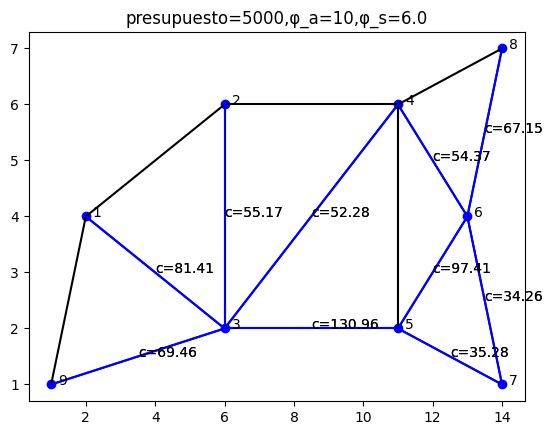

par 0-4, 7.762937000000001 pax
par 0-5, 8.255016000000001 pax
par 0-6, 9.723597 pax
par 0-7, 4.761408 pax
par 1-4, 4.171461 pax
par 1-5, 12.742542 pax
par 1-6, 2.122149 pax
par 1-7, 3.563676 pax
par 2-4, 14.331576000000002 pax
par 2-5, 5.833352 pax
par 2-6, 8.936295 pax
par 2-7, 8.495292000000001 pax
par 8-4, 17.969067000000003 pax
par 8-5, 8.860178999999999 pax
par 8-6, 4.946152 pax
par 8-7, 8.481384 pax
130.956083/130.956094


In [73]:
# Model Delay ARCS
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

map_x = [2,6,6,11,11,13,14,14,1]
map_y = [4,6,2,6,2,4,1,7,1]

phi_s_coef = 1
n = 9
presupuestos = [5000]
phis = [10]

org = 6
des = 0
fig, ax = plt.subplots(len(presupuestos),len(phis))
cost_per_pax = np.zeros((len(presupuestos),len(phis)))
d = 0
for presupuesto in presupuestos:
     c = 0
     for phi in phis:
          arcos = np.loadtxt(f"LP_presupuesto={presupuesto}_phi={phi}_phi-coef={phi_s_coef}_clineal_arcos")
          estaciones = np.loadtxt(f"LP_presupuesto={presupuesto}_phi={phi}_phi-coef={phi_s_coef}_clineal_estaciones")
          fnew = np.loadtxt(f"LP_presupuesto={presupuesto}_phi={phi}_phi-coef={phi_s_coef}_clineal_fnew")
          fcur = np.loadtxt(f"LP_presupuesto={presupuesto}_phi={phi}_phi-coef={phi_s_coef}_clineal_fcur")
          fij = np.loadtxt(f"LP_presupuesto={presupuesto}_phi={phi}_phi-coef={phi_s_coef}_clineal_flujos")
          print(fij[n*org+0,n*des+1])
          coste = 0
          coste_ruta = 0
          for i in range(n):
               coste += c_estaciones[i]*estaciones[i]
          for i,j in product(range(n),repeat = 2):
               if j in candidatos[i]:
                    coste += c_arcos[i,j]*arcos[i,j]
          dem_a = 0
          for oo,dd in product(range(n),repeat = 2):
               dem_a += demanda[oo,dd]*fnew[oo,dd]
          
          

          for i in range(n):
               #ax[d,c].annotate(str(i+1), (map_x[i]+0.2, map_y[i]))
               plt.annotate(str(i+1), (map_x[i]+0.2, map_y[i]))
               if estaciones[i] > 1:
                    plt.scatter(map_x[i],map_y[i],c="blue")
               else:
                    plt.scatter(map_x[i],map_y[i],c="black")

          for i,j in product(range(n),repeat = 2):
               if (j in candidatos[i]):
                    repr_x = [map_x[i],map_x[j]]
                    repr_y = [map_y[i],map_y[j]]
                    if (arcos[i,j] > 1):
                         #if (fij[n*org+i,n*des+j] >= 0.05) or (fij[n*org+j,n*des+i] >= 0.05):
                              #ax[d,c].plot(repr_x,repr_y,c="red")
                              #plt.plot(repr_x,repr_y,c="red")
                              #ax[d,c].annotate(f"c={arcos[i,j]:.2f},f={demanda[org,des]*fij[n*org+i,n*des+j]}/{demanda[org,des]}",[(map_x[i]+map_x[j])/2,(map_y[i]+map_y[j])/2])
                              #plt.annotate(f"c={arcos[i,j]:.2f},f={demanda[org,des]*fij[n*org+i,n*des+j]}/{demanda[org,des]}",[(map_x[i]+map_x[j])/2,(map_y[i]+map_y[j])/2])
                         #if (fij[n*org+i,n*des+j] < 0.05) and (fij[n*org+j,n*des+i] < 0.05):
                              #ax[d,c].plot(repr_x,repr_y,c="blue")
                              plt.plot(repr_x,repr_y,c="blue")
                              plt.annotate(f"c={arcos[i,j]:.2f}",[(map_x[i]+map_x[j])/2,(map_y[i]+map_y[j])/2])
                    elif (arcos[i,j] <= 1) and (i<j):
                         plt.plot(repr_x,repr_y,c="black")
          for oo,dd,ii,jj in product(range(n),repeat=4):
               coste_ruta += distancias[ii,jj]*demanda[oo,dd]*fij[n*oo+ii,n*dd+jj]
          for oo,dd in product(range(n),repeat = 2):
               coste_ruta += coste_actual[oo,dd]*demanda[oo,dd]*fcur[oo,dd]
               coste_ruta += demanda[oo,dd]*fcur[oo,dd]

          objetivo = coste + coste_ruta
          cost_per_pax[d,c] = objetivo
          print(f"phi={phi},b={presupuesto},demanda={dem_a},coste_pax={coste/dem_a},objetivo = {objetivo}")
          #print(f"presupuesto = {presupuesto}, phi = {phi}: coste = {coste}, demanda = {dem_a}, objetivo = {objetivo}")
          plt.title(f"presupuesto={presupuesto},φ_a={phi},φ_s={0.6*phi}")
          c += 1
     d += 1
#fig.suptitle("Model B")
#fig.set_size_inches(25,8)
print(f"{fnew[org,des]*demanda[org,des]}/{demanda[org,des]}")
print(np.exp(-distancias[0,2] - distancias[2,4] - distancias[4,6] - 1/(eps + 28.397))/(np.exp(-distancias[0,2] - distancias[2,4] - distancias[4,6] - 1/(eps + 28.397)) + np.exp(-coste_actual[6,0]))*demanda[org,des])
plt.show()
i = 2
j = 4
s = 0
for o,d in product(range(n),repeat = 2):
     s += fij[n*o+i,n*d+j]*demanda[o,d]
     if fij[n*o+i,n*d+j] > 0.05:
          print(f"par {o}-{d}, {fij[n*o+i,n*d+j]*demanda[o,d]} pax")
print(f"{s}/{arcos[i,j]}")

